In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [3]:
print(tf.__version__)

2.6.0


In [4]:
tf.random.set_seed(42)
np.random.seed(42)

In [5]:
train_df = pd.read_csv('../data/ch18_train.csv')
val_df = pd.read_csv('../data/ch18_val.csv')
test_df = pd.read_csv('../data/ch18_test.csv')

print(train_df.shape, val_df.shape, test_df.shape)

(24464, 7) (6990, 7) (3495, 7)


## `DataWindow` class 

In [6]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='Global_active_power', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [7]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [8]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

## Baseline models 

In [9]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['Global_active_power'])

### Repeat last value 

In [10]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])

In [11]:
baseline_last = MultiStepLastBaseline(label_index=column_indices['Global_active_power'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(multi_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(multi_window.test, verbose=0)

217/217 [==============================] - 1s 2ms/step - loss: 0.1788 - mean_absolute_error: 0.3018


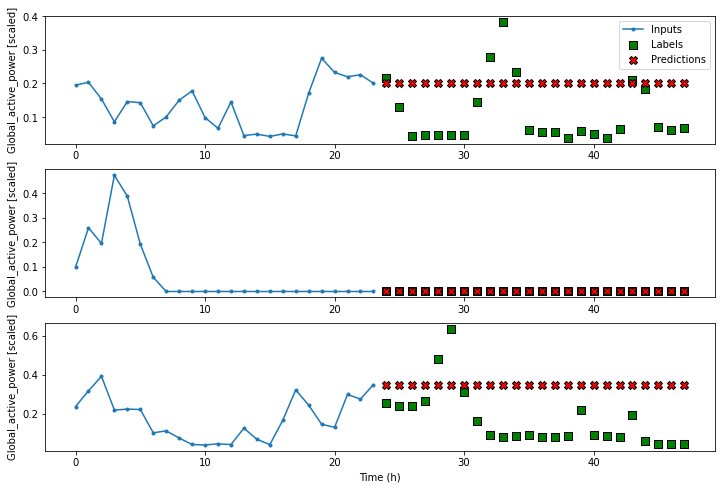

In [12]:
multi_window.plot(baseline_last)

plt.savefig('figures/CH18_F07_peixeiro.png', dpi=300)

### Repeat last day 

In [13]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [14]:
baseline_repeat = RepeatBaseline(label_index=column_indices['Global_active_power'])

baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.val)
performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.test, verbose=0)

217/217 [==============================] - 0s 556us/step - loss: 0.1786 - mean_absolute_error: 0.2962


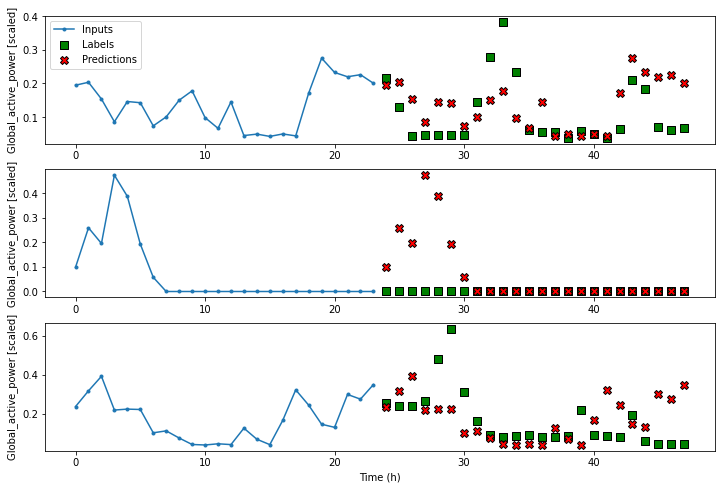

In [15]:
multi_window.plot(baseline_repeat)

plt.savefig('figures/CH18_F08_peixeiro.png', dpi=300)

## Linear model 

In [16]:
label_index = column_indices['Global_active_power']
num_features = train_df.shape[1]

linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(linear, multi_window)

val_performance['Linear'] = linear.evaluate(multi_window.val)
performance['Linear'] = linear.evaluate(multi_window.test, verbose=0)

Epoch 1/50
764/764 [==============================] - 1s 848us/step - loss: 0.0178 - mean_absolute_error: 0.1036 - val_loss: 0.0141 - val_mean_absolute_error: 0.0917
Epoch 2/50
764/764 [==============================] - 1s 768us/step - loss: 0.0162 - mean_absolute_error: 0.0977 - val_loss: 0.0140 - val_mean_absolute_error: 0.0909
Epoch 3/50
764/764 [==============================] - 1s 767us/step - loss: 0.0161 - mean_absolute_error: 0.0974 - val_loss: 0.0140 - val_mean_absolute_error: 0.0911
Epoch 4/50
764/764 [==============================] - 1s 764us/step - loss: 0.0162 - mean_absolute_error: 0.0974 - val_loss: 0.0140 - val_mean_absolute_error: 0.0904
Epoch 5/50
764/764 [==============================] - 1s 764us/step - loss: 0.0161 - mean_absolute_error: 0.0974 - val_loss: 0.0140 - val_mean_absolute_error: 0.0900
Epoch 6/50
764/764 [==============================] - 1s 760us/step - loss: 0.0162 - mean_absolute_error: 0.0974 - val_loss: 0.0140 - val_mean_absolute_error: 0.0905
Epoc

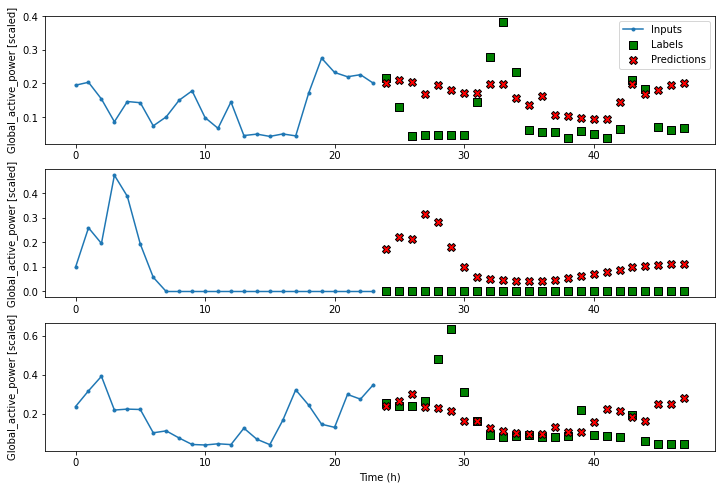

In [17]:
multi_window.plot(linear)

plt.savefig('figures/CH18_F09_peixeiro.png', dpi=300)

## Dense model 

In [18]:
dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(dense, multi_window)

val_performance['Dense'] = dense.evaluate(multi_window.val)
performance['Dense'] = dense.evaluate(multi_window.test, verbose=0)

Epoch 1/50
764/764 [==============================] - 2s 1ms/step - loss: 0.0155 - mean_absolute_error: 0.0928 - val_loss: 0.0129 - val_mean_absolute_error: 0.0827
Epoch 2/50
764/764 [==============================] - 1s 1ms/step - loss: 0.0147 - mean_absolute_error: 0.0896 - val_loss: 0.0129 - val_mean_absolute_error: 0.0832
Epoch 3/50
764/764 [==============================] - 1s 1ms/step - loss: 0.0147 - mean_absolute_error: 0.0896 - val_loss: 0.0129 - val_mean_absolute_error: 0.0845
Epoch 4/50
764/764 [==============================] - 1s 1ms/step - loss: 0.0146 - mean_absolute_error: 0.0895 - val_loss: 0.0129 - val_mean_absolute_error: 0.0836
Epoch 5/50
764/764 [==============================] - 1s 1ms/step - loss: 0.0146 - mean_absolute_error: 0.0894 - val_loss: 0.0130 - val_mean_absolute_error: 0.0827
Epoch 6/50
217/217 [==============================] - 0s 773us/step - loss: 0.0129 - mean_absolute_error: 0.0856


## LSTM model 

In [19]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(lstm_model, multi_window)

val_performance['LSTM'] = lstm_model.evaluate(multi_window.val)
performance['LSTM'] = lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
764/764 [==============================] - 5s 6ms/step - loss: 0.0166 - mean_absolute_error: 0.0975 - val_loss: 0.0131 - val_mean_absolute_error: 0.0866
Epoch 2/50
764/764 [==============================] - 4s 5ms/step - loss: 0.0147 - mean_absolute_error: 0.0903 - val_loss: 0.0129 - val_mean_absolute_error: 0.0852
Epoch 3/50
764/764 [==============================] - 4s 5ms/step - loss: 0.0145 - mean_absolute_error: 0.0892 - val_loss: 0.0128 - val_mean_absolute_error: 0.0835
Epoch 4/50
764/764 [==============================] - 4s 5ms/step - loss: 0.0144 - mean_absolute_error: 0.0888 - val_loss: 0.0129 - val_mean_absolute_error: 0.0832
Epoch 5/50
764/764 [==============================] - 4s 5ms/step - loss: 0.0144 - mean_absolute_error: 0.0886 - val_loss: 0.0127 - val_mean_absolute_error: 0.0841
Epoch 6/50
764/764 [==============================] - 4s 5ms/step - loss: 0.0143 - mean_absolute_error: 0.0884 - val_loss: 0.0128 - val_mean_absolute_error: 0.0843
Epoch 7/50
764/7

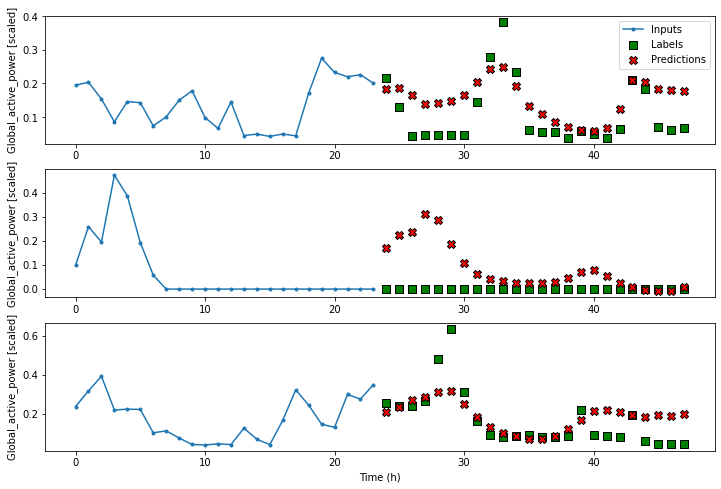

In [20]:
multi_window.plot(lstm_model)

plt.savefig('figures/CH18_F10_peixeiro.png', dpi=300)

## CNN model 

In [21]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

cnn_multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=24, label_columns=['Global_active_power'])

In [22]:
cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_model, cnn_multi_window)

val_performance['CNN'] = cnn_model.evaluate(cnn_multi_window.val)
performance['CNN'] = cnn_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/50
763/763 [==============================] - 2s 2ms/step - loss: 0.0156 - mean_absolute_error: 0.0932 - val_loss: 0.0130 - val_mean_absolute_error: 0.0836
Epoch 2/50
763/763 [==============================] - 1s 1ms/step - loss: 0.0145 - mean_absolute_error: 0.0891 - val_loss: 0.0128 - val_mean_absolute_error: 0.0839
Epoch 3/50
763/763 [==============================] - 1s 1ms/step - loss: 0.0144 - mean_absolute_error: 0.0888 - val_loss: 0.0128 - val_mean_absolute_error: 0.0834
Epoch 4/50
763/763 [==============================] - 1s 1ms/step - loss: 0.0144 - mean_absolute_error: 0.0888 - val_loss: 0.0130 - val_mean_absolute_error: 0.0830
Epoch 5/50
763/763 [==============================] - 1s 1ms/step - loss: 0.0144 - mean_absolute_error: 0.0886 - val_loss: 0.0127 - val_mean_absolute_error: 0.0833
Epoch 6/50
763/763 [==============================] - 1s 1ms/step - loss: 0.0144 - mean_absolute_error: 0.0885 - val_loss: 0.0128 - val_mean_absolute_error: 0.0829
Epoch 7/50
763/7

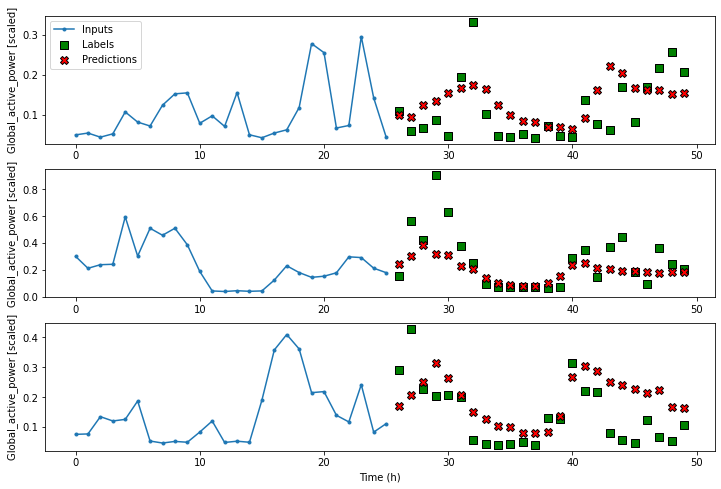

In [23]:
cnn_multi_window.plot(cnn_model)

plt.savefig('figures/CH18_F11_peixeiro.png', dpi=300)

## CNN + LSTM model 

In [24]:
cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_lstm_model, cnn_multi_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/50
763/763 [==============================] - 6s 6ms/step - loss: 0.0160 - mean_absolute_error: 0.0951 - val_loss: 0.0129 - val_mean_absolute_error: 0.0845
Epoch 2/50
763/763 [==============================] - 4s 6ms/step - loss: 0.0144 - mean_absolute_error: 0.0887 - val_loss: 0.0128 - val_mean_absolute_error: 0.0842
Epoch 3/50
763/763 [==============================] - 4s 6ms/step - loss: 0.0143 - mean_absolute_error: 0.0881 - val_loss: 0.0128 - val_mean_absolute_error: 0.0841
Epoch 4/50
763/763 [==============================] - 4s 6ms/step - loss: 0.0142 - mean_absolute_error: 0.0879 - val_loss: 0.0129 - val_mean_absolute_error: 0.0841
Epoch 5/50
763/763 [==============================] - 4s 6ms/step - loss: 0.0142 - mean_absolute_error: 0.0877 - val_loss: 0.0129 - val_mean_absolute_error: 0.0845
Epoch 6/50
217/217 [==============================] - 0s 2ms/step - loss: 0.0130 - mean_absolute_error: 0.0832


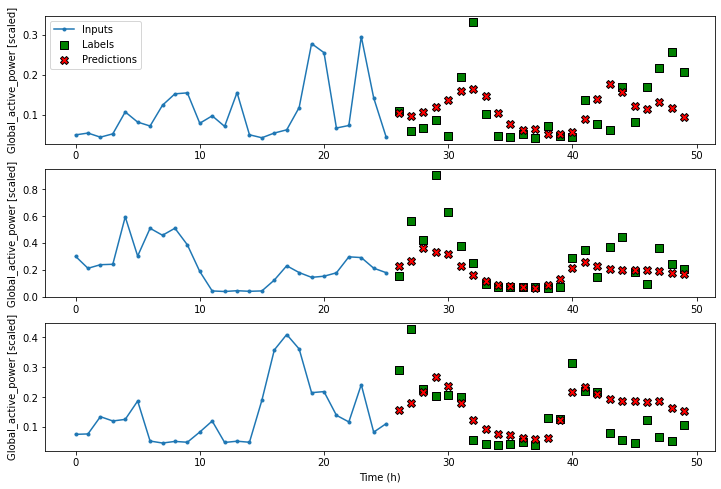

In [25]:
cnn_multi_window.plot(cnn_lstm_model)

plt.savefig('figures/CH18_F12_peixeiro.png', dpi=300)

## Autoregressive LSTM 

In [26]:
class AutoRegressive(Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units)
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True)
        self.dense = Dense(train_df.shape[1])
        
    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)
                
        return prediction, state
    
    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)
        
        predictions.append(prediction)
        
        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)
            
            prediction = self.dense(x)
            predictions.append(prediction)
        
        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        
        return predictions

In [27]:
AR_LSTM = AutoRegressive(units=32, out_steps=24)

history = compile_and_fit(AR_LSTM, multi_window)

val_performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.val)
performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.test, verbose=0)

Epoch 1/50
764/764 [==============================] - 9s 9ms/step - loss: 0.0175 - mean_absolute_error: 0.1027 - val_loss: 0.0132 - val_mean_absolute_error: 0.0853
Epoch 2/50
764/764 [==============================] - 6s 8ms/step - loss: 0.0142 - mean_absolute_error: 0.0882 - val_loss: 0.0126 - val_mean_absolute_error: 0.0837
Epoch 3/50
764/764 [==============================] - 6s 8ms/step - loss: 0.0140 - mean_absolute_error: 0.0870 - val_loss: 0.0126 - val_mean_absolute_error: 0.0831
Epoch 4/50
764/764 [==============================] - 6s 8ms/step - loss: 0.0139 - mean_absolute_error: 0.0865 - val_loss: 0.0122 - val_mean_absolute_error: 0.0817
Epoch 5/50
764/764 [==============================] - 6s 8ms/step - loss: 0.0138 - mean_absolute_error: 0.0861 - val_loss: 0.0121 - val_mean_absolute_error: 0.0813
Epoch 6/50
764/764 [==============================] - 6s 8ms/step - loss: 0.0137 - mean_absolute_error: 0.0857 - val_loss: 0.0121 - val_mean_absolute_error: 0.0818
Epoch 7/50
764/7

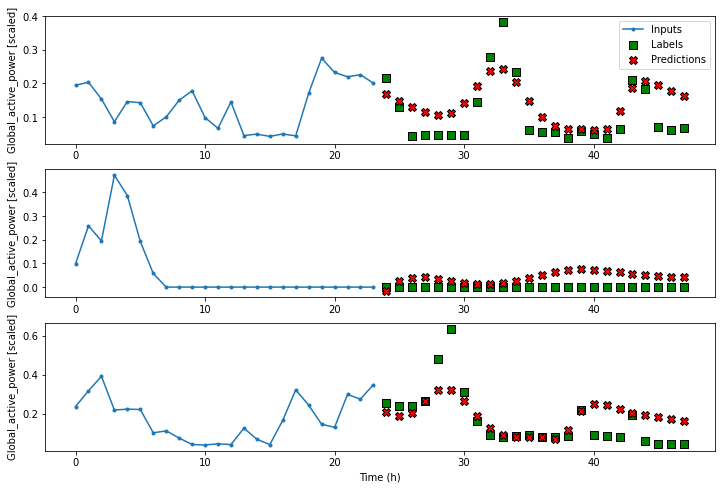

In [28]:
multi_window.plot(AR_LSTM)

plt.savefig('figures/CH18_F13_peixeiro.png', dpi=300)

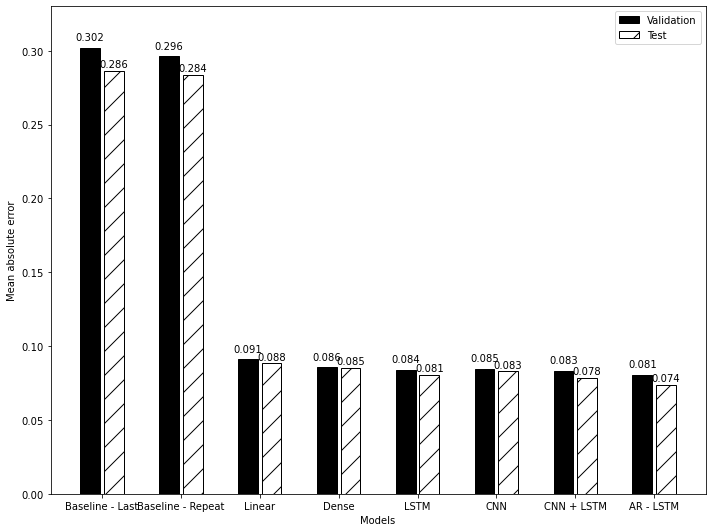

In [29]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.005, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.33)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/CH18_F14_peixeiro.png', dpi=300)